## Alumno: Santiago Germino.
### MSE 4ta cohorte.

# Predicción lineal

 En la figura se observa un filtro forward predictor con una estructura FIR

<img src="predictor.png" alt="Predictor lineal"/>

Las entradas a los taps son $u(i-1), u(i-2), ..., u(i-M)$. La idea de este filtro es predecir el valor siguiente de la señal $u(i)$, denotado $\hat{u}(i)$.

El objetivo es encontrar el vector de taps *${\hat{w}}$* que minimice la suma cuadrática de los errores de predicción, $e_f$

$$e_f = \sum_{i=M+1}^{N} \left|f_M(i)\right|^2$$

#### Encontrar:

1. La matriz de $M$ por $M$ de correlación los taps de entrada 

2. El vector de correlación cruzada $M$ por $1$ entre los taps de entrada del predictor y la respuesta deseada $u(i)$ 

3. El valor mínimo de $e_f$

4. El vector de taps *${\hat{w}}$*

5. Una vez obtenida la ecuación del filtro predictor, calcular el filtro para $N$ valores de una realización de la siguiente señal:

$$u(i) = sen(2\pi\omega_0i + \phi_0) + 0.02n(i)$$

siendo $\omega_0 = 3, \phi_0 = \pi / 4$ y $n(i)$ un ruido gaussiano de varianza unitaria. Tomar N = 100 y M = 4

6. Ver cómo se comporta el filtro (es decir, su capacidad de predicción) para otras realizaciones del mismo proceso.

#### Consejos orientativos:
* Pensar a $N$ como un valor mayor a $M$. Es decir, $N$ representa la cantidad TOTAL de puntos de $u(i)$ y $M$ es la cantidad de taps del filtro. En un momento dado, hay $M$ puntos de $u(i)$ dentro del filtro.
* Podemos pensar que el primer valor válido de $u$ es $u(1)$, es decir la secuencia empieza $u(1), u(2), \dots ,u(N)$
* El filtro produce resultados desde $i = M+1$ hasta $i = N$, es decir, $N-M$ predicciones.
* Al ser las señales reales, los valores hermíticos de los vectores o matrices son los traspuestos.
* Para multiplicación de matrices, utilizar @. Por ejemplo:

In [1]:
import numpy as np
a = np.array([[1,2,3],[2,3,1]])
b = np.array([-1,4,3])
c = a @ b
c

array([16, 13])

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal as sig
from numpy.linalg import inv

## Implementación del cálculo de los filtros (matrices, correlación cruzada, error cuadratico, taps, etc).

In [3]:
# Calcula matriz hermite segun Weiner
# N: orden del filtro
# M: cantidad de taps
# taps: señal de entrada del filtro
def CalcHermiteA (N, M, taps):
    ha = np.zeros ((M, (N - M)))

    for i in np.arange(N - M):
        ha[:, i] = taps[np.arange (M + i, i, -1)]

    return ha


# Calcula coeficientes w segun Weiner
# ha: matriz hermite A
# d: señal
def CalcW (ha, d):
    phi	= ha @ ha.transpose()
    z	= ha @ d
    w	= inv (phi) @ z

    return w


# Calcula error cuadratico medio al usar Weiner
# ha: matriz hermite A
# sig: señal
def CalcECM(ha, sig):
    hd	= sig.transpose ()
    A	= ha.transpose ()
    ecm	= hd @ sig - hd @ A @ inv(ha @ A) @ ha @ sig

    return ecm


# Generación de señal de prueba
#
# Parametros:
# N: numero de coeficientes
# M: orden del filtro
# std: varianza de ruido gausiano
def GenTestSignal (N, M, std):
    # Parametros constantes    
    # Sampling: fs = frecuencia, ts = periodo, tmax = intervalo de muestreo
    fs		= 300
    ts		= 1 / fs
    tmax	= 2
    samples	= fs * tmax
    # Señal senoidal: a = amplitud, w = frecuencia, p = fase
    a0		= 1
    w0		= 3
    p0		= np.pi / 4
    # Ruido Gausiano: mu = media, std = varianza
    mu		= 0

    tt			= np.linspace (0, tmax, samples).flatten ()
    sig_pure	= np.sin (2 * np.pi * w0 * tt + p0) * a0 
    # Additive Gaussian Noise
    sig_noise	= np.random.normal (mu, std, np.size(sig_pure))
    sig_input	= sig_pure + sig_noise

    ha			= CalcHermiteA (N, M, sig_input)
    w			= CalcW        (ha, sig_pure[M+1:N+1])
    ecm			= CalcECM      (ha, sig_pure[M+1:N+1])
    sig_output	= ha.transpose () @ w

    return  {
                'signal': { 'tt': tt[M:N], 'pure': sig_pure[M:N], 'input': sig_input[M:N], 'output': sig_output },
                'params': { 'ecm': ecm, 'M': M, 'N': N, 'std': std }
            }

## Implementación de dibujado de señales y tests de parametros.

In [4]:
def DrawSignals (data):
    plt.figure (num=None, figsize=(18, 12))
    plt.title  ('Señal de entrada según N = ' + str(data['params']['N']) + ', M = ' + str(data['params']['M']) 
                    +  ', std = ' + str(data['params']['std']) + ', error = ' + str(data['params']['ecm']))
    
    plt.plot   (data['signal']['tt'], data['signal']['pure'], 'g', linewidth=5)
    plt.plot   (data['signal']['tt'], data['signal']['input'], 'r-')
    plt.plot   (data['signal']['tt'], data['signal']['output'], 'b-')

    plt.xlabel ('Tiempo')
    plt.ylabel ('Amplitud')
    plt.grid   (True)
    plt.legend (('Señal senoidal pura, original',
                 'Señal de entrada con ruido',
                 'Señal filtrada'),
                 loc='best')
    plt.show   ()
    
                
def DrawTest (M, N, std):
    DrawSignals (GenTestSignal (M, N, std))

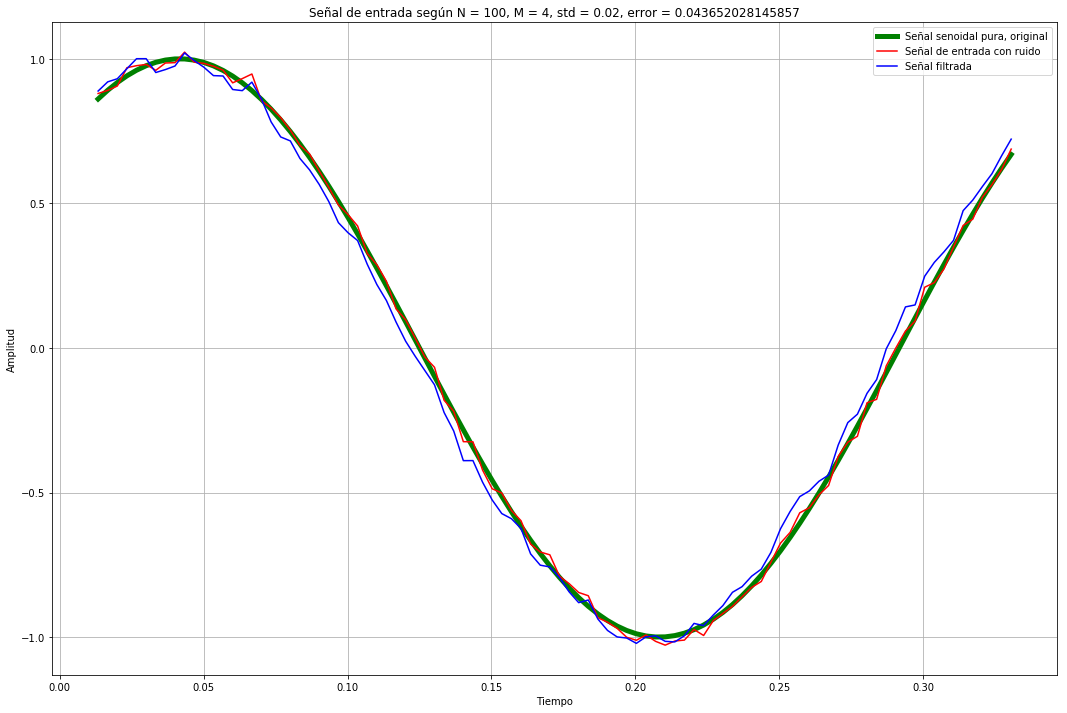

In [5]:
DrawTest (100, 4, 0.02)

## Observando la forma de onda resultante y teniendo en cuenta que el error cuadratico calculado, se puede afirmar que el filtro elimina eficazmente el ruido de la señal.

### A continuación se observa como se comporta el filtro ante otros valores de M, N y std (Varianza del ruido gaussiano). Se comienza por modificar N = 20.

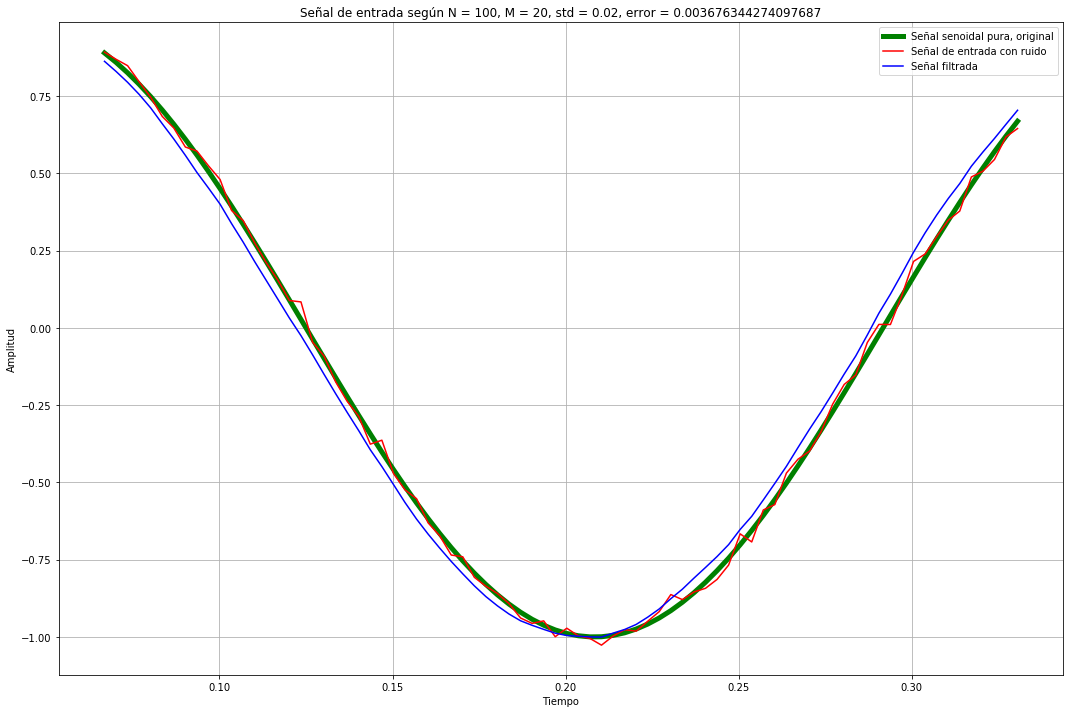

In [6]:
DrawTest (100, 20, 0.02)

## Un incremento de los coeficientes del filtro produce una eliminación mas efectiva del ruido. Esto puede apreciarse tanto observando el gráfico como así también el valor de error cuadratico.

### A continuacíon se mantiene el valor original de M pero se incrementa la varianza del ruido gaussiano (std = 0.40)

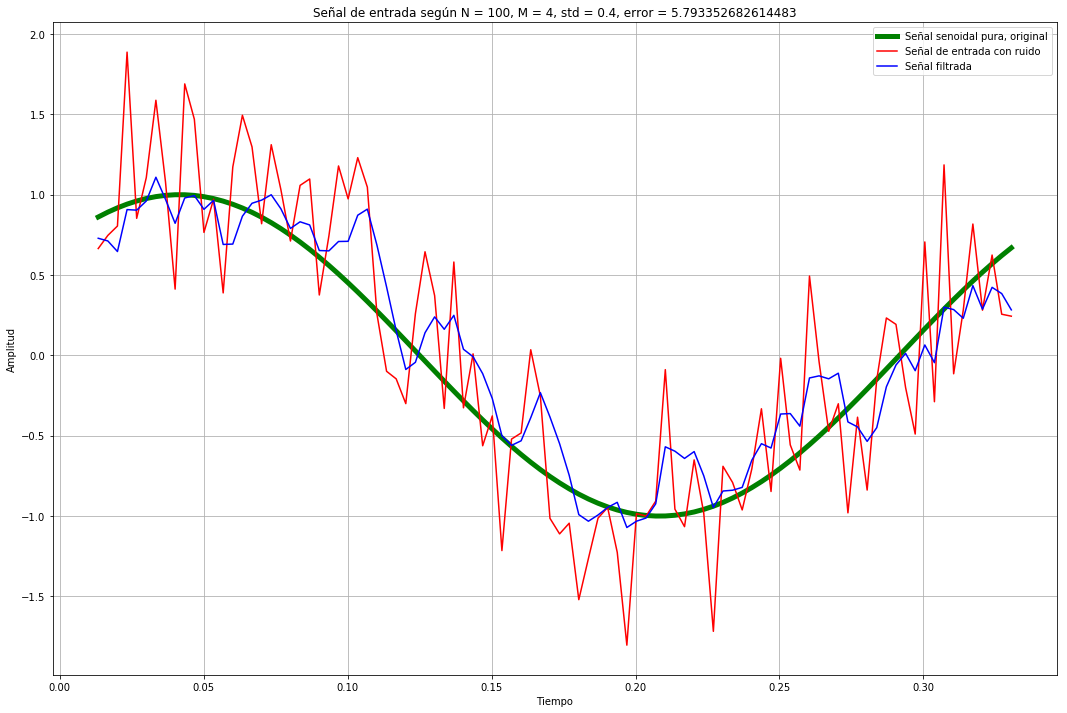

In [7]:
DrawTest (100, 4, 0.40)

## Un orden de M = 4 no es suficiente para filtrar con eficacía un ruido gaussiano elevado (ver error).

### A continuación se eleva el orden M a 20, manteniendo la varianza del ruido gaussiano en 0.40


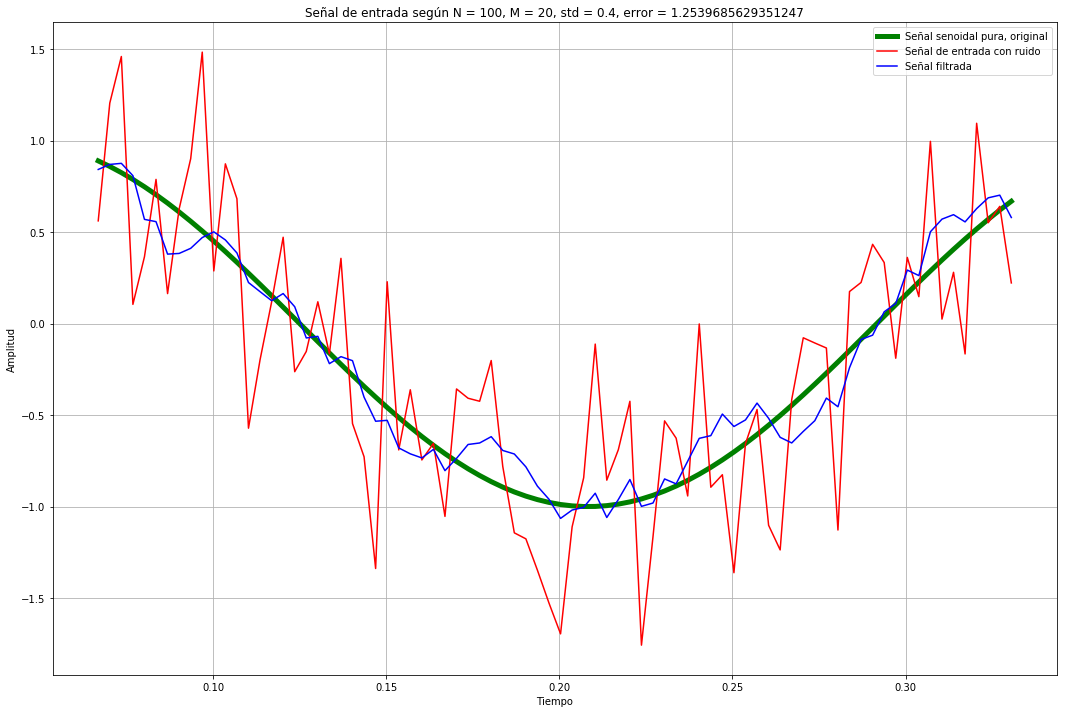

In [8]:
DrawTest (100, 20, 0.40)

## De igual modo que en los ensayos anteriores, se observa que elevar el orden M de 4 a 20 mejora notablemente el filtrado de la señal.

## Esto se corrobora subiendo a continuación el orden M de 20 a 30. Puede observarse un mejor filtrado aun, por supuesto a costa de una mayor demanda de procesamiento del filtro.

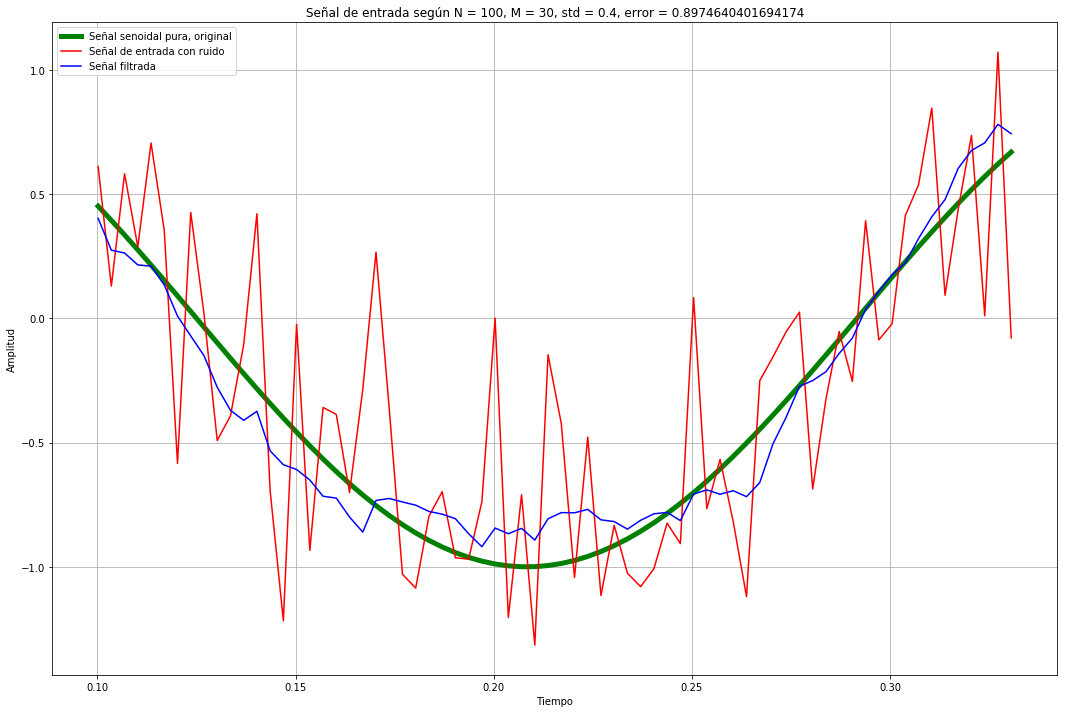

In [9]:
DrawTest (100, 30, 0.40)